In [1]:
# !pip install torchinfo
# !pip install pytorch-nlp
# !pip install wandb

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchnlp.nn import LockedDropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import joblib
import torch.nn as nn
import matplotlib.pyplot as plt
from torchinfo import summary
import wandb
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data = joblib.load("dataframe.pkl")

data.shape

scaled_data loaded:


In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length, prediction_horizon, scaler=None):

        self.seq_length = seq_length
        self.data = data
        
        if scaler:
            self.data['Global_active_power'] = scaler.fit_transform(
                self.data[['Global_active_power']].values
            )
        self.data = self.data.values
        
        self.X, self.y = self.create_sequences(self.data, seq_length, prediction_horizon)

    def create_sequences(self, data, seq_length, prediction_horizon):
        X, y = [], []
        for i in tqdm(range(0, len(data) - seq_length - prediction_horizon), desc="Creating sequences"):
            X.append(data[i:i + seq_length, :]) 
            y.append(data[i + seq_length:i + seq_length + prediction_horizon, :]) 
        return np.array(X), np.array(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

In [ ]:
train_size = int(len(data) * 0.8)  
train_data = data[:train_size]
test_data = data[train_size:]
seq_length =  720
prediction_horizon = 10


In [ ]:
scaler = MinMaxScaler()
train_dataset = TimeSeriesDataset(train_data, seq_length, prediction_horizon, scaler=scaler)
test_dataset = TimeSeriesDataset(test_data, seq_length, prediction_horizon, scaler=scaler)

# Create DataLoaders
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Creating sequences: 100%|██████████| 414322/414322 [00:00<00:00, 969513.81it/s]


In [6]:
for batch_X, batch_y in train_loader:
    print(f"Train Batch X shape: {batch_X.shape}")  # (batch_size, seq_length, num_features)
    print(f"Train Batch y shape: {batch_y.shape}")  # (batch_size, prediction_horizon)
    break

# Example: Iterate through the test DataLoader
for batch_X, batch_y in test_loader:
    print(f"Test Batch X shape: {batch_X.shape}")  # (batch_size, seq_length, num_features)
    print(f"Test Batch y shape: {batch_y.shape}")  # (batch_size, prediction_horizon)
    break

Train Batch X shape: torch.Size([1024, 720, 3])
Train Batch y shape: torch.Size([1024, 10, 3])
Test Batch X shape: torch.Size([1024, 720, 3])
Test Batch y shape: torch.Size([1024, 10, 3])


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):

        _, (h, c) = self.lstm(x)
        return h, c


class Decoder(nn.Module):
    def __init__(self, hidden_size, input_size, num_layers, fcc_intermediate):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers


        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)


        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, fcc_intermediate)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fcc_intermediate, 1)

    def forward(self, decoder_input, h, c):

        out, (h, c) = self.lstm(decoder_input, (h, c))
        out = self.fc1(out[:, -1, :])
        out = self.relu(out)
        out = self.fc2(out)
        return out, h, c


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, fcc_intermediate, prediction_horizon):
        super(Model, self).__init__()
        self.num_layers = num_layers
        self.encoder = Encoder(input_size, hidden_size, num_layers)
        self.decoder = Decoder(hidden_size, input_size, num_layers, fcc_intermediate)  
        self.prediction_horizon = prediction_horizon

    def forward(self, x, teacher_forcing_targets=None, teacher_forcing_ratio=0.5):

        batch_size = x.size(0)

        h, c = self.encoder(x)
        num_directions = h.shape[0] // self.num_layers


        h = h.view(self.num_layers, num_directions, h.shape[1], h.shape[2]) 
        c = c.view(self.num_layers, num_directions, c.shape[1], c.shape[2])


        # print(h.shape)
        h = h.sum(dim=1) 
        c = c.sum(dim=1)


        decoder_input = x[:, -1, :].unsqueeze(1) 
        outputs = []

        for t in range(self.prediction_horizon):
            out, h, c = self.decoder(decoder_input, h, c)  
            outputs.append(out)

            if self.training and teacher_forcing_targets is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = teacher_forcing_targets[:, t, :].unsqueeze(1) 
            else:
                other_features = teacher_forcing_targets[:, t, 1:].unsqueeze(1)
                predicted_power = out[:, :1].unsqueeze(1) 
                decoder_input = torch.cat([predicted_power, other_features], dim=-1)

        return torch.cat(outputs, dim=1) 


In [ ]:
input_size = 3  # Number of features
hidden_size = 64
num_layers = 2
fcc_intermdeiate = 8
model = Model(input_size, hidden_size, num_layers, fcc_intermdeiate, prediction_horizon).to(device)


summary(
    model,
    input_data=batch_X.to(device),
    teacher_forcing_targets=batch_y.to(device)
)

In [9]:
# Define the custom loss function
def combined_loss(predictions, targets, alpha=0.5):

    mse_loss = nn.MSELoss()(predictions, targets)
    mae_loss = nn.L1Loss()(predictions, targets)
    return alpha * mse_loss + (1 - alpha) * mae_loss


In [10]:
def train_epoch(model, train_loader, optimizer, device):

    model.train()
    train_loss = 0.0
    for batch_X, batch_y in tqdm(train_loader, desc="Training"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # Forward pass
        outputs = model(batch_X, teacher_forcing_targets=batch_y)
        loss = combined_loss(outputs, batch_y[:,:,0].squeeze())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(train_loader)


def val_epoch(model, val_loader, device):

    model.eval()
    val_loss = 0.0
    test_predictions = []
    test_targets = []

    with torch.no_grad():
        for batch_X, batch_y in tqdm(val_loader, desc="Validation"):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X, teacher_forcing_targets=batch_y)
            loss = combined_loss(outputs, batch_y[:,:,0].squeeze())

            val_loss += loss.item()

            test_predictions.append(outputs.cpu().numpy())
            test_targets.append(batch_y[:, :, 0].squeeze().cpu().numpy())


    return val_loss / len(val_loader), test_predictions, test_targets



In [11]:
wandb.login(key="7664f3b17a98ffe7c64b549e349123b61a9d3024")
run = wandb.init(
    reinit = False, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "Power-Forcasting", ### Project should be created in your wandb account
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aaayush (aaayush-carnegie-mellon-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
learning_rate = 0.0001
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=0)


# Training and Validation
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Train for one epoch
    avg_train_loss = train_epoch(model, train_loader, optimizer, device)
    train_losses.append(avg_train_loss)

    # Validate for one epoch
    avg_val_loss, test_predictions, test_targets = val_epoch(model, test_loader, device)
    val_losses.append(avg_val_loss)

    # Log epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Curr LR: {float(optimizer.param_groups[0]['lr'])}")

    scheduler.step(avg_val_loss)

run.finish()


Validation: 100%|██████████| 405/405 [00:45<00:00,  8.97it/s]


Epoch [1/20], Train Loss: 0.0146, Val Loss: 0.0110, Curr LR: 0.0001


Validation: 100%|██████████| 405/405 [00:45<00:00,  8.96it/s]


Epoch [2/20], Train Loss: 0.0090, Val Loss: 0.0113, Curr LR: 0.0001


Validation: 100%|██████████| 405/405 [00:45<00:00,  8.98it/s]


Epoch [3/20], Train Loss: 0.0082, Val Loss: 0.0108, Curr LR: 5e-05


Validation: 100%|██████████| 405/405 [00:45<00:00,  8.93it/s]


Epoch [4/20], Train Loss: 0.0078, Val Loss: 0.0108, Curr LR: 5e-05


Validation: 100%|██████████| 405/405 [00:45<00:00,  8.93it/s]


Epoch [5/20], Train Loss: 0.0075, Val Loss: 0.0105, Curr LR: 2.5e-05


Validation: 100%|██████████| 405/405 [00:45<00:00,  8.90it/s]


Epoch [6/20], Train Loss: 0.0074, Val Loss: 0.0104, Curr LR: 2.5e-05


Training:   6%|▌         | 90/1621 [00:28<07:57,  3.21it/s]


KeyboardInterrupt: 

In [13]:
def evaluate_predictions(scaler, test_predictions, test_targets):

    # Concatenate predictions and targets across all batches
    predictions = np.concatenate(test_predictions, axis=0)  # Shape: (num_samples, prediction_horizon)
    targets = np.concatenate(test_targets, axis=0)  # Shape: (num_samples, prediction_horizon)

    # Reshape to match scaler's expected input shape: (num_samples * prediction_horizon, 1)
    predictions = predictions.reshape(-1, 1)
    targets = targets.reshape(-1, 1)

    # Rescale predictions and targets to their original range
    predictions_rescaled = scaler.inverse_transform(predictions)
    targets_rescaled = scaler.inverse_transform(targets)

    # Compute evaluation metrics
    mae = mean_absolute_error(targets_rescaled, predictions_rescaled)
    rmse = np.sqrt(mean_squared_error(targets_rescaled, predictions_rescaled))
    mape = np.mean(np.abs((targets_rescaled - predictions_rescaled) / targets_rescaled)) * 100

    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    }


metrics = evaluate_predictions(scaler, test_predictions, test_targets)

print(f"Mean Absolute Error (MAE): {metrics['MAE']:.4f}")
print(f"Root Mean Squared Error (RMSE): {metrics['RMSE']:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {metrics['MAPE']:.2f}%")


Mean Absolute Error (MAE): 0.2116
Root Mean Squared Error (RMSE): 0.4605
Mean Absolute Percentage Error (MAPE): 26.50%


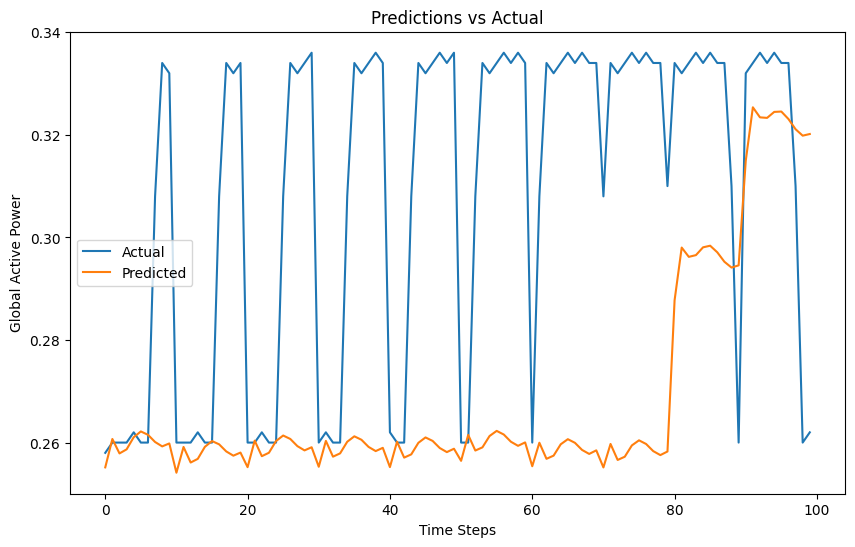

In [14]:
predictions = np.concatenate(test_predictions, axis=0)
targets = np.concatenate(test_targets, axis=0)

predictions = predictions.reshape(-1, 1)
targets = targets.reshape(-1, 1)

# Rescale for visualization
predictions_rescaled = scaler.inverse_transform(predictions)
targets_rescaled = scaler.inverse_transform(targets)

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(targets_rescaled[:100], label='Actual')
plt.plot(predictions_rescaled[:100], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Global Active Power')
plt.title('Predictions vs Actual')
plt.legend()
plt.show()

In [15]:
torch.save(model.state_dict(), "lstm_model.pth")